# Hands-on Lab 7: Controls Part 1
## EECS 16B: Designing Information Devices and Systems II, Spring 2022

Updated by Steven Lu, Kaitlyn Chan (2021)

Updated by Steven Lu (2022)

## <span style="color:navy">Table Of Contents</span>
-----
* [Introduction](#intro)
* [Part 1: Open-Loop Control](#part1)
* [Part 2: Closed-Loop Control](#part2)
* [Part 3: Open-Loop Comparison](#part3)


<a id='intro'></a>
## <span style="color:navy">Introduction</span>
In the previous lab, we developed a linear model for our system, finding the parameters $\theta$ and $\beta$ for each wheel, in order to better understand how our inputs get "translated" into wheel velocity. In this lab, we will use our model from the previous lab to control S1XT33N's trajectory to be a straight line. We will do so in 2 different ways: open-loop control and closed-loop control. Of course, S1XT33N would be lacking if it could only drive in a straight line. In the next lab, we will address how to enable S1XT33N to turn within the controller we develop here. 


**Remember to document all design choices you made and explain them in the final lab report!**

## Lab Note
* [Lab Note](https://drive.google.com/file/d/1SR4YwB1iaNtiTu8LiePX8lgwNYXpqPVr/view?usp=sharing)

Review the lab note. The lab note provides a technical review of the concepts covered in lab as well as theoretical connections. **You should read the lab notes before your lab section.** They serve as a review and will be helpful as a reference during section.


## Pre-Lab

### Complete the pre-lab assignment before doing the lab. For all students, submit your answers to the Gradescope assignment "[ALL LAB] Pre-Lab 7: Controls Part 1". Pre-Lab 7 is due on Sunday, March 27 at 11:59pm. No late submissions will be accepted.


### Help Request Link: https://links.eecs16b.org/lab-help-sp22

<a id='part1'></a>
# <span style="color:navy">Part 1: Open-Loop Control</span>

## 1.0 Introduction to Open-Loop Control

We will begin by exploring how to control our car using open-loop control. Open-loop control refers to a controller that does not take in feedback from the target system; it simply sets the inputs to what it calculates to be the proper values and lets the system run. For S1XT33N, open loop control takes the form of the Launchpad calculating the inputs $u_L$ and $u_R$ to set in order to have both wheels run at the same velocity v* (the operating velocity we calculated in the previous lab), setting its PWM output pins to those input values and then letting the motors run.

### <span style="color:red">**First, fill in your model parameters and target velocity from Lab 6: System ID below.**</span>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [28]:
# YOUR PARAMETERS HERE
theta_left = 0.2686
theta_right = 0.2564
beta_left = -27.54
beta_right = -30.28
v_star = 75.0

simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [29]:
params = np.array([(theta_left, theta_right),
                   (beta_left, beta_right)])
d0 = (0,  0)
sim_length = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

<a id='part1.1'></a>
## 1.1 Open-Loop Controller Design

Now, design an open-loop controller that uses the desired wheel velocity, `v_star`, to set the input `u` to an appropriate PWM value. To do this, solve your model from the previous lab for the inputs $u_L[i]$ and $u_R[i]$ that respectively make the model wheel velocities $v_L[i]$ and $v_R[i]$ equal to the desired velocity $v^*$.

Tip: Since we defined your parameters $\theta_L$, $\theta_R$, etc in a code block above, you can use those same variables within your open-loop functions.

In [30]:
# DESIGN YOUR OPEN-LOOP CONTROL HERE
def drive_straight_left_ol(v_star):
    """Returns the open loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    x = v_star + beta_left
    return x / theta_left

def drive_straight_right_ol(v_star):
    """Returns the open loop input 'u' for the right wheel"""
    x = v_star + beta_right
    return x / theta_right

<a id='part1.2'></a>
## 1.2 Open-Loop Simulation


Now, let's do a quick simulation to check the behavior of the car based on our functions above.

### Mismatch
In the System ID lab, we found $\beta_{L,R}$ and $\theta_{L,R}$ to model the two wheels. However, there could be a mismatch between the estimated model parameters $\beta_{L,R}, \theta_{L,R}$ and real model parameters $\beta^*_{L,R}, \theta^*_{L,R}.$ In this simulation, we assumed that the mismatch error is the same for both $\beta_{L,R}$ and $\theta_{L,R}$


$$\theta^*_{L,R}=\theta_{L,R} \times (1+\text{mismatch_error})$$
$$\beta^*_{L,R}=\beta_{L,R} \times (1+\text{mismatch_error})$$


In the left two plots, we assume the physical system perfectly matches our model. On the right, we assume the physical system is 10% different from our model, meaning the model parameters of the wheels have a 10% mismatch. Don't worry too much about the $\delta$ plot for now; we will come back to what this is later on in the lab.

The 5th plot titled "Trajectory of the car" shows how the car would travel depending on which model is used. In the perfect model, the car is driving straight. In the case with model mismatch, the car continues to spin right.


Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = unbounded


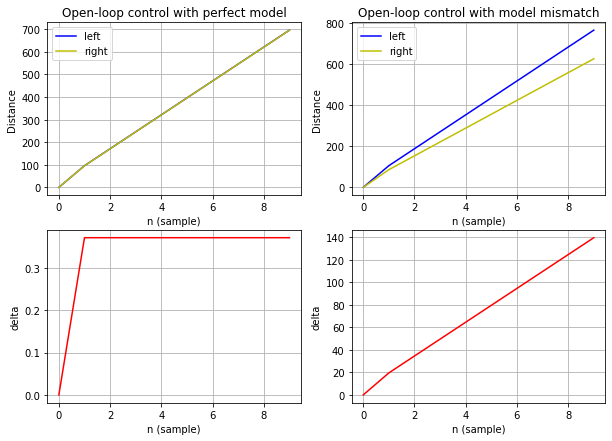

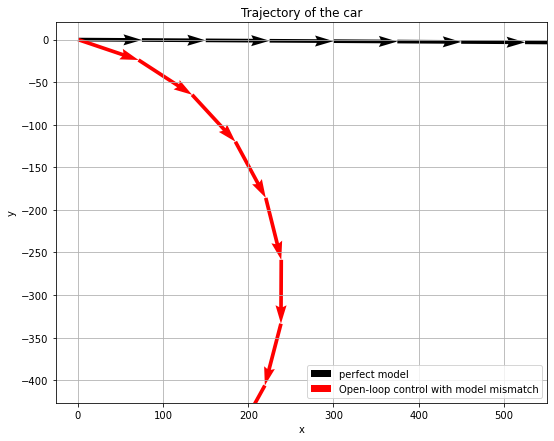

In [25]:
titles = ["Open-loop control with perfect model",
          "Open-loop control with model mismatch"]
_ = utils.two_sims(titles, simulator, v_star, drive_straight_left_ol, drive_straight_right_ol)
utils.plot_car_traj(titles[1], simulator, v_star, drive_straight_left_ol, drive_straight_right_ol,mismatch_error=0.1,sim_length=sim_length)

<a id='part1.3'></a>
## 1.3 Jolt Calculation

In the simulations above, we applied a maximum PWM to each wheel to "jolt" the motors from rest. However, in reality, we may not want to use the same PWM values for both wheels, as each side responds differently to the input; doing so could cause the car to immediately turn at the start and veer off course. 

So, we need jolt values that result in the two wheels attaining the same velocity, which we will choose to be whichever is the lower velocity between the left wheel's and the right wheel's maximum velocity. The inputs that correspond to this velocity will be our jolt values.

- **Copy your `data_coarse.txt` file from Lab 6: System ID into the same directory as this iPython notebook.**
- Run the code below to find and print your initial jolt values.
- These jolt values should be the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

int left_jolt = 200;
int right_jolt = 195;


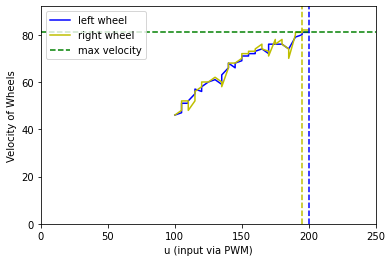

In [31]:
left_jolt, right_jolt = utils.find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

<a id='part1.4'></a>
## 1.4 Open-Loop Implementation

Now we will implement the controller on the Launchpad. The sketch **`open_loop.ino`** contains some code that implements the open loop control.

- **If you've changed any of the pins from their default values in System ID, make sure those changes are reflected in the pin definitions.**

- Fill in these values in `CODE BLOCK CON1`:
    - desired velocity: `v_star` 
    - estimated parameters: `theta_left`, `theta_right`, `beta_left`, `beta_right`
    - initial jolt values: `left_jolt`, `right_jolt`
    
    
- Additionally, we need to compute the PWM input to the motors in `CODE BLOCK CON2`:
    - Complete `driveStraight_left()` and `driveStraight_right()` to compute `left_cur_pwm` and `right_cur_pwm` (the PWM inputs for each wheel required for a desired v_star)
    - **Note: Energia code requires using C/C++ syntax, rather than the Python syntax you used to write the drive_straight_left_ol and drive_straight_right_ol functions above. Make sure you only copy the body of the function over into open_loop.ino, not the def statement itself. Depending on how you wrote the function, you may need to modify the syntax to fit C/C++ syntax.**
    - Tip: Your $\theta$ and $\beta$ values are defined globally at the top of the file, so you are able to reference them inside your function.
    
    
- Fill out `CODE BLOCK CON0` to calculate the control inputs using the functions from `CODE BLOCK CON2`.
- Upload the sketch to your Launchpad. Press the leftmost button (2.1) to start the car to test that your motors are working.
- **Make sure that the car is suspended above the desk.** Your car wheels are going to move.
- <span style="color:red">**Remember, never plug in both the 5V pin on the Launchpad and the USB at the same time!**</span>

Once you are satisfied that your motors work and your open loop control is implemented, put the car on the ground. Make sure the castor wheel is still straight, or else your car may already turn upon starting. Make sure the motor switch is on (and that both your motors are still plugged in) and press the `RST` button, then leftmost (2.1) button on your Launchpad.

Does S1XT33N drive in a straight line? Most likely, you will see that it is still turning quite a bit, unless your two wheels are almost perfectly in sync. 

So how do we enable our car to drive in a straight line then? The answer is closed-loop control.

-----

<a id='part2'></a>
# <span style="color:navy">Part 2: Closed-Loop Control</span>

<a id='part20'></a>
## 2.0 Introduction to Closed-Loop Control

In order to correct for the limitations of open-loop control, we need a way for the Launchpad to detect that the car is turning. Fortunately, we already have encoders on the motors that can measure the distance traveled by each wheel. We can take this information and "feed it back" to the Launchpad as an input so that it can make a decision to increase or decrease the left or right wheel velocity to adjust the trajectory back to a straight line, creating a closed-loop controller.

<a id='part21'></a>
## 2.1 Closed-Loop Design

As part of our closed-loop controller, we need to pass the controller the feedback factors f_left and f_right. These determine how much the Launchpad, when given a certain $\delta$ value, adjusts the left and right inputs to correct for turns or disturbances. As a reminder, $\delta[i] = d_L[i] - d_R[i]$.

Take a look at the open-loop simulations again. Pay attention to the delta plots and how the delta value evolves over time in the simulation, and how the delta value corresponds to the trajectory. You may have noticed that even in the simulation where the car is driving in a straight line, $\delta$ may not have converged to 0. A non-zero constant $\delta$ just means S1XT33N is traveling straight, just in a different direction than the original bearing. 

In Parts 2.1-2.4, we mostly just care about whether S1XT33N eventually drives straight in a reasonable amount of time. It is okay if the car starts off turning and then drives in a straight line; this indicates steady state error. We will take the steady state error $\delta_{ss}$ into account in Part 2.5 of this lab and correct for it.

Using the model derived in the lab note, we can begin implementing the closed-loop controller. Start by running the code below to set up the simulator, and filling in the two functions that compute the inputs to pass to the left and right wheels using the desired velocity `v_star`, error term `delta`, and feedback factors `f_left` and `f_right` (which will be defined in the next section).

In [32]:
simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [33]:
# DESIGN YOUR CLOSED-LOOP CONTROL HERE USING f_left AND f_right AS YOUR FEEDBACK TERMS
def drive_straight_left_cl(v_star, delta):
    """Returns the closed loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    return (v_star - (f_left * delta) + beta_left) / theta_left

def drive_straight_right_cl(v_star, delta):
    """Returns the closed loop input 'u' for the right wheel"""
    # YOUR CODE HERE
    return (v_star + (f_right * delta) + beta_right) / theta_right

<a id='part22'></a>
## 2.2 Closed-Loop Simulation and f-Value Selection

With our input-calculating functions out of the way, we next need to choose values for the feedback factors so that the $\delta[i]$ update equation is stable. There should be a range of parameter values that make it stable, so we will need to tune the gains to get the desired performance.

Take a look at each pair of perfect/mismatched-model plots below for each f-value pair and relate how our choice in f-values affects the car's performance. For each pair of plots, ask yourself these questions:
1. Does the car seem to drive straight in the perfectly matched model?
2. Does the car seem to correct for any errors that arise from a mismatched model? Does it end up driving straight?
3. How well does the car correct for errors?
3. Why do the chosen f-values make our system exhibit such behaviors?

<span style='color:red'>**Try the 5 different sets of gains below and see the effect of each.**</span>

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = unbounded
fL=-0.3, fR=0.3
Eigenvalue of system: 1-fL-fR=1; marginally stable


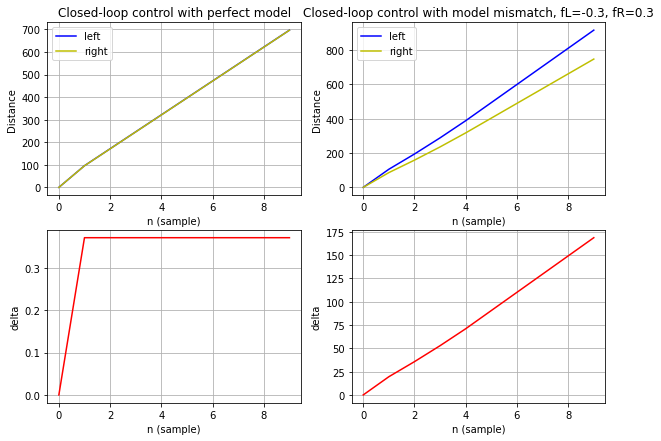

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 15.00
fL=0.5, fR=0.5
Eigenvalue of system: 1-fL-fR=0; stable, corrects error in one step


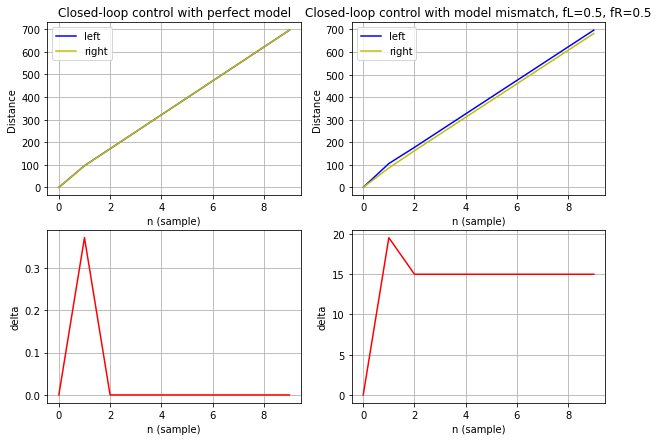

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = oscillatory
fL=1, fR=1
Eigenvalue of system: 1-fL-fR=-1; oscillatory, marginally stable


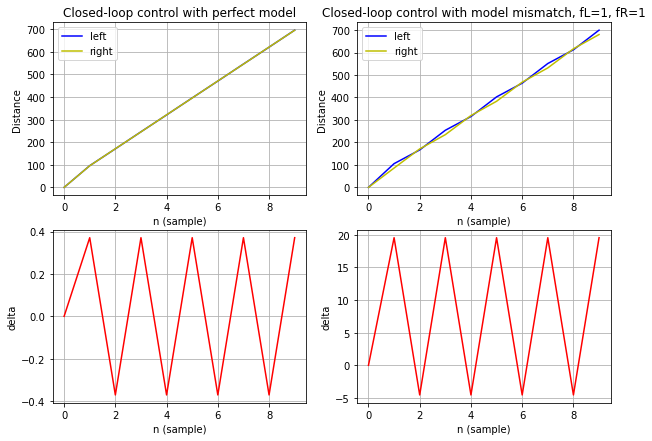

Perfect model: Steady state error = unbounded
Non-ideal model: Steady state error = oscillatory
fL=1.1, fR=1.1
Eigenvalue of system: 1-fL-fR=-1.2; oscillatory, unstable


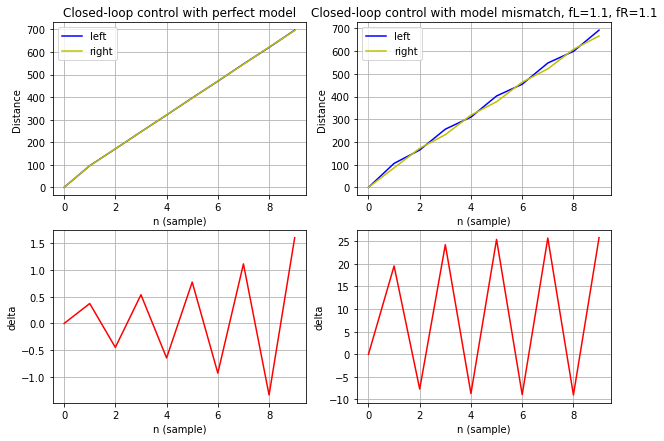

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 37.20
fL=0.2, fR=0.2
Eigenvalue of system: 1-fL-fR=0.6; stable


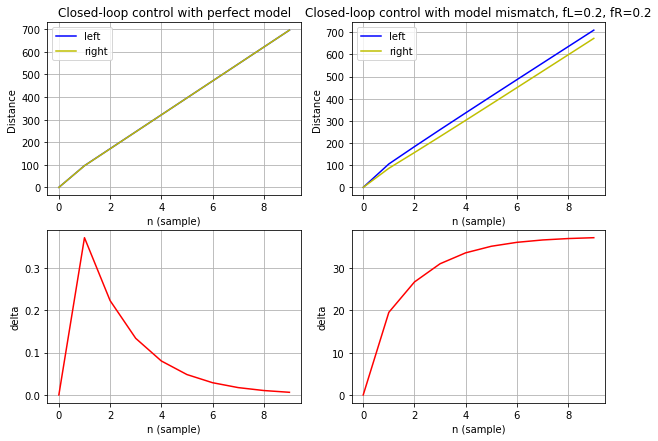

In [34]:
f_left, f_right = None, None
steady_state_error = None

# Maps description of f_values to (f_left, f_right)
f_values = {
    "marginally stable": (-0.3, 0.3),
    "stable, corrects error in one step": (0.5, 0.5),
    "oscillatory, marginally stable": (1, 1),
    "oscillatory, unstable": (1.1, 1.1),
    "stable": (0.2, 0.2),
}

for key in f_values:
    f_left, f_right = f_values[key]

    titles = ["Closed-loop control with perfect model",
              "Closed-loop control with model mismatch, fL={}, fR={}".format(f_left, f_right)]
    _, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

    print("fL={}, fR={}".format(f_left, f_right))
    print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
    plt.show()
    steady_state_error = delta[-1]

Now that you've taken a look at the behavior of various different values for f_left and f_right, choose your own for your car! Fill in your chosen values in the code below to see how your set compares to the behavior of the other sets of values. Does it do what you expected it to?

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 15.96
fL=0.2, fR=0.8
Eigenvalue of system: 1-fL-fR=0; stable


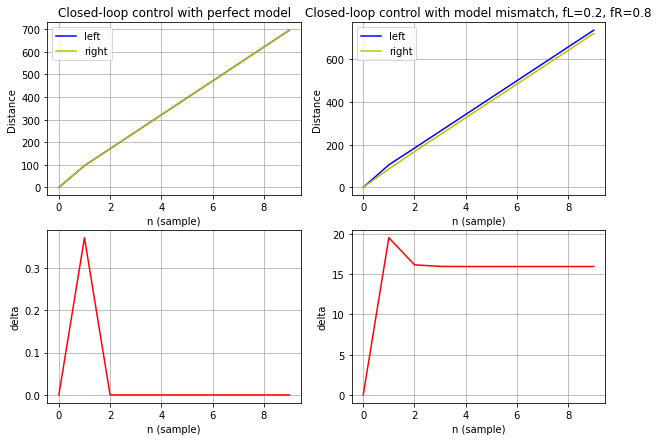

In [37]:
f_left, f_right = 0.2, 0.8 # TODO: Fill in your chosen f values

titles = ["Closed-loop control with perfect model",
          "Closed-loop control with model mismatch, fL={}, fR={}".format(f_left, f_right)]
_, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

print("fL={}, fR={}".format(f_left, f_right))
print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
plt.show()
steady_state_error = delta[-1]

<a id='part23'></a>
## 2.3 Closed-Loop Implementation

Now implement the controller on the Launchpad. The sketch **`closed_loop.ino`** contains some code that implements the closed loop control. 

- If you've changed any of the pins from their default values, make sure those changes are reflected in the pin definitions.
- Fill out `CODE BLOCK CON1` with your control gains **`f_left`** and **`f_right`** as well as your theta, beta, and v_star values from System ID.
    - A good starting point for controlling your car would be to set `f_left` = `f_right` = 0.5. Finding the values that work best for your car is an iterative process, and you'll have to fine tune these values in order to have the car drive straight.
- Fill out `CODE BLOCK CON2` with your closed-loop control scheme.
    - **As a reminder, Energia code uses C/C++ syntax! You might not be able to simply copy and paste and expect it to compile perfectly.**
- Fill out `CODE BLOCK CON0` in the body of the loop function to calculate the control inputs. Inspect this code to see how the control system is implemented. For now, ignore the term `delta_ss`, as it's currently set to 0.
- Upload the sketch to your LaunchPad.
    - Make sure that the car is suspended above the desk. Your car wheels are going to move.
    - Check that the wheels are moving as you expect them to.
    - <span style="color:red">**Remember, never plug in both the 5V pin on the Launchpad and the USB at the same time!**</span>
    - **If you use your hand to add some friction on one of the wheels (i.e. slow it down), does the feedback correct the other wheel?**

Once you are satisfied that your motors work and your closed-loop control is implemented, run the car on the ground. Make sure the castor wheel is straight, or else your car may already turn upon starting. If it behaves erroneously (for example the car oscillates), try different eigenvalues. Our simulations compare our possibly mismatched linear model with a linear approximation of our car. In reality, the car is a nonlinear system, so the simulations may not align perfectly with reality.

<a id='part24'></a>
## 2.4 f-Value Tuning

How did the car behave? It probably didn't go perfectly straight with the first set of f values that you picked. In order to find the "right" f values, we will need to analyze the behavior of our car. For our system, we want $\delta[i]$ (the blue line) to converge to 0 in a reasonable amount of time.

small f-values | large f-values
- | - 
![alt](images/small_f.png) | ![alt](images/large_f.png)
 
The above plots can be summarized as:
- if f_left and f_right are too small, it takes a long time to converge to our desired solution.
- if f_left and f_right are too big, oscillations happen.

We can use this information to help guide us to f-values that get our car going straight. More example cases are in the lab note, and check out [this youtube playlist](https://www.youtube.com/playlist?list=PLQ1OVCqw6RUPgCmv8H6y9qbcMBT8lotDt) if you need some examples of what each case could look like (note that the videos in the playlist call them "k-values" instead of "f-values").

With that in mind, adjust your f-values in the code and run the car on the ground again, observing its trajectory. This is an iterative process; you will likely have to try several sets of f-values until you find one that works well for your particular car. If you find yourself having a lot of trouble narrowing in on some, ask staff for help!

**Note:** It's possible that the car curves *slightly* over long distances, even if it the car thinks it's traveling straight. This can be due to factors such as mechanical differences past the shaft of the motor, including slight variation in wheel size or wheel wobble, or encoder calibration issues. We can fix this later in the next part of the project. If you think this is happening for your car, ask a staff member to confirm for you.

**Tips:**
 - Don't randomly guess on the f-values! This will take you a long time to find the ones that make your car drive straight. Your tuning should always be based off of the previous iterations' behavior; don't just randomly choose values. Try to be smart about how you change the f-values from iteration to iteration. If your car is turning to the left, think about how to change each f-value, either by increasing or decreasing its value, to fix it.
 - If you're trying to figure out whether to increase or decrease your f_left or f_right based off of your car's behavior, you can try setting the values to two opposite extremes (i.e. f_left = .9, f_right = .1 or f_left = .1, f_right = .9) and test it to see which one makes your car drive straighter.


<a id='part25'></a>

## 2.5 Steady State Error Correction

If delta doesn't converge to 0 but to some non-zero constant, this means that the car is driving straight, but not with the same bearing as you placed the car down with (i.e. the car has turned but drives straight eventually). However, we want the car to travel in (approximately) the same direction as when it starts moving. We can accomplish this by manually adding the known steady state error $\delta_{ss}$ to each calculation of the error $\delta$.

Our error term is now defined as $\delta[i]=d_L - d_R + \delta_{ss}$.


Steady state error = 0.00


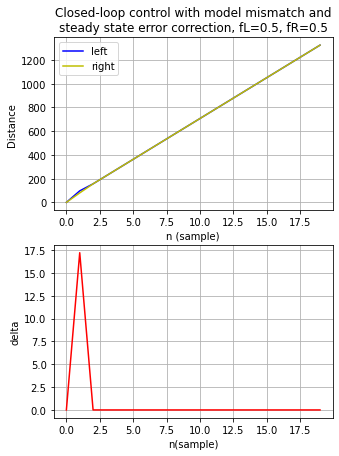

In [20]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
d = simulator.simulate(
    v_star, drive_straight_left_cl, drive_straight_right_cl, mismatch_error=0.1, sim_length=20, offset=steady_state_error)
delta = simulator.plot(d)
plt.title("Closed-loop control with model mismatch and\nsteady state error correction, fL={}, fR={}"
          .format(f_left, f_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')
plt.xlabel('n(sample)')
plt.grid()

`closed_loop.ino` collects data as it runs, including $\delta[i]$. Like `dynamics_data.ino` from the System ID lab, data will be written to Flash Memory at the end of the run so that data is not lost upon cutting off power to the Launchpad. After you have finished tuning your f-values, do the following:
- Set `WRITE = 1` at the top of the `closed_loop.ino` program.
- Upload the program, and press the leftmost button (2.1) when you are ready to run the car.
- Let the car run until it settles to (approximately) straight; it should do so by the time it naturally comes to a stop.
- Unplug the batteries from the car, and then unplug the `5V` pin of your launchpad from your regulator circuits.
- Set `WRITE = 0` at the top of the `closed_loop.ino` program.
- Upload the program to your launchpad and open the serial monitor (baud rate 38400). Press the leftmost button (2.1) to start the code and print the collected delta values to the monitor.     
- Note the steady state value $\delta_{ss}$.
    - The first column of the printed data is $\delta$ over time.
    - **If $\delta$ doesn't reach steady state (converges to a value), the car is not going straight according to the sensors.**
        - It's okay if it isn't exactly constant; just be sure the variation is small in proportion to the average value.
    - The value that the $\delta$ converges to is the $\delta_{ss}$ value.

## Implementing Steady State Error Correction

- Input your value of $\delta_{ss}$ in `CODE BLOCK CON3` in **`closed_loop.ino`**.
- Convince yourself that we need to *add* this value in `CODE BLOCK CON0`.
    - For example, if the car drives straight but turned right from its initial heading, we want the right wheel to travel farther so it turns back towards the left. Adding a positive number to delta accomplishes this.
- Set `WRITE = 1` at the top of the `closed_loop.ino` program and upload it.
- Unplug the Launchpad from the computer, plug in your batteries into the breadboard, and then plug in the `5V` pin of your Launchpad.
- Run your car on the ground and observe its behavior with steady state error correction.

<a id='part3'></a>

# <span style="color:blue">Part 3: Open-Loop Comparison</span>

To compare your control scheme to an open-loop model, you can set both of your f-values to zero. Try running your car with f-values of zero. Does your car behave similarly? Does it go straight?

Why do you think you see the behavior you see?

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF</span>

- **Have all questions, code, and plots completed in this notebook.**

- <span style="color:green"> **Demonstrate your car going straight.** We will also check your f-values. To ensure standardization of checkoffs across sections, here is our definition of “straight” based on the floor tiling your car has to travel within at various locations inside and outside the Cory 125 lab: </span>
   - Inside Cory 125: 1x4 tiles
   - Outside Cory 125: 3x11 on black tiles
   - Side entrance hallway, from the pink to red lines: 2x7 tiles

- **Be prepared to answer conceptual questions about the lab.**
 

### Checkoff Request Link: https://links.eecs16b.org/lab-checkoff-sp22


**After checkoff, please:**

- <span style="color:#ff0000"> **DO NOT DISMANTLE ANY CIRCUITS FROM YOUR PROJECT BREADBOARD! You will need them for the rest of the project!**</span>

- Make sure that all electrical components that you received in your lab kit are stored neatly and safely for use in future labs.

- **Remove your battery caps from your batteries to avoid accidental short circuits that might drain their voltage.**

- **SAVE ALL YOUR DATA!!** Data stored on the lab computers often gets deleted automatically. Please store it on your personal flash drive or cloud storage like Google Drive, and not on the lab computers! If you used DataHub, it should save through your CalNet ID.

- **Clean up your lab bench areas! This includes turning off all lab equipment, putting all lab equipment probes back on the racks, returning all components you borrowed, putting the rest of the components back in your lab kits neatly, and throwing away any stripped wires.**

- ### **Remember what each part of your circuit is for (Record this in a Google doc or somewhere else safe). You will need everything for the final lab report!**
